# Task: Model the dynamics of gender in intro CS


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import libraries


import sys
sys.path.append('tools/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplt
import seaborn as sns
import tools
import inputData
   

## Exploring the Data

Let's go ahead and read in the student dataset first.


In [3]:
data = inputData.preprocess()

In [4]:
data = data.query('gender == "Female" or gender == "Male"')
data = data.reset_index(drop=True)


print '{:d}{:20}{:d}{:20}'.format(len(data.query('gender == "Male"')), ' male students, and ',
                                  len(data.query('gender == "Female"')),
                                  ' female students consented to participate in this study')
                        

494 male students, and 388 female students consented to participate in this study


#### Drop the columns that aren't needed for the model

In [5]:
columnsNotNeeded = ['timestamp', 'consent','name', 'name_1', 'name_2', 
                    'morecs','snap_python','hiphop_d1','hiphop_d2','song_ct', 'major'] 
data.drop(columnsNotNeeded, axis=1, inplace=True)
                   

### Preprocess feature columns

There are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `prcs_2`. These can be reasonably converted into `1`/`0` (binary) values. For the columns whose values are `Nan`, I am going to convert these to `0`. 


**Note**: These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['Yes', 'No'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            # e.g. 'reason' => 'reason_class_Interested' , 'reason_class_Other'
            col_data = pd.get_dummies(col_data, prefix=col)

        outX = outX.join(col_data)  # collect column(s) in output dataframe
        outX.fillna(0, inplace=True) # make sure all NaN <missing> values are set to 0

    return outX



In [7]:
data = preprocess_features(data)
print "Processed feature columns ({}):- {}".format(len(data.columns), list(data.columns))


Processed feature columns (47):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'atcsgender_1', 'atcsgender_2', 'atcsgender_3', 'atcsjob_1', 'atcsjob_2', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'classmtr', 'clet_1', 'clet_2', 'cltrcmp_1', 'cltrcmp_2', 'gender_Female', 'gender_Male', 'grade_B or above', 'grade_B or below', 'mtr_1', 'mtr_2', 'mtr_3', 'prcs_1', 'prcs_2', 'prcs_3', 'prcs_4', 'prcs_5', 'prepared', 'priorcs10', 'reason_class_Interested', 'reason_class_Other']


## Scaling
Linearly scale each attribute to the range [−1, +1] or [0, 1].



In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df = data

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

data = df_scaled
data.tail()

,atcs_1,atcs_2,atcs_3,atcs_4,atcs_5,atcs_6,atcs_7,atcs_8,atcs_9,atcsgender_1,...,mtr_3,prcs_1,prcs_2,prcs_3,prcs_4,prcs_5,prepared,priorcs10,reason_class_Interested,reason_class_Other
877,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.00,0.0,1.0,0.0
878,0.00,0.50,0.25,1.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0
879,1.00,1.00,1.00,0.25,0.75,1.00,1.00,0.75,1.00,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.00,0.0,0.0,0.0
880,1.00,1.00,0.75,0.25,0.50,0.75,0.50,0.50,0.75,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0
881,0.75,0.75,0.50,0.25,0.25,1.00,0.75,0.50,1.00,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.25,0.0,1.0,0.0


### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the 47 features is actually relevant for understanding the impact of gender on belonging. We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

- Based on domain knowledge, we will limit the features to three dimensions:
    - atcs: Attitudes about CS competency.
    - blg: Sense of belonging in the CS classroom.
    - atct: Understanding of computational thinking.
    
This reduces the set of features from 47 to 21.   
We are going to use the feature **`'blg_1'`** as our target 


In [9]:
atcs = ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 
        'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9']# self reported attitude about CS competency
atct = ['atct_1', 'atct_2', 'atct_3', 'atct_4', 
        'atct_5', 'atct_6', 'atct_7', 'atct_8'] # Self reported attitudes about computational thinking
blg = ['blg_1', 'blg_2', 'blg_3', 'blg_4'] # Sense of belonging in the class room
clet = ['clet_1', 'clet_2'] # Social implications and ethics
gender = ['gender_Female', 'gender_Male' ]

itemDimensions = {}
itemDimensions['atcs'] = atcs
itemDimensions['atct'] = atct
itemDimensions['blg'] = blg
itemDimensions['gender'] = gender

In [10]:
list_of_lists = [
itemDimensions['atcs'], 
itemDimensions['blg'],
itemDimensions['atct'],
itemDimensions['gender']
]

flattened = [val for sublist in list_of_lists for val in sublist]

In [11]:
for key in itemDimensions:
    try:
        inputData.describeData(itemDimensions[key])
    except:
        print"{:15}{:20}".format(key, 'Preprocessed feature, no description')

gender         Preprocessed feature, no description
atct_1         I am good at solving a problem by thinking about similar problems I’ve solved before.
atct_2         I have good research skills.
atct_3         I am good at using online search tools.
atct_4         I am persistent at solving puzzles or logic problems.
atct_5         I know how to write computer programs
atct_6         I am good at building things.
atct_7         I’m good at ignoring irrelevant details to solve a problem.
atct_8         I know how to write a computer program to solve a problem.
atcs_1         I like to use computer science to solve problems.
atcs_2         I can learn to understand computing concepts.
atcs_3         I can achieve good grades (C or better) in computing courses.
atcs_4         I do not like using computer science to solve problems.
atcs_5         I am confident that I can solve problems by using computation
atcs_6         The challenge of solving problems using computer science appeals t

In [12]:
display(data[flattened].head())
data = data[flattened]

print data.columns

,atcs_1,atcs_2,atcs_3,atcs_4,atcs_5,atcs_6,atcs_7,atcs_8,atcs_9,blg_1,...,atct_1,atct_2,atct_3,atct_4,atct_5,atct_6,atct_7,atct_8,gender_Female,gender_Male
0,0.5,0.75,1.00,0.50,0.75,0.75,0.75,0.50,0.75,0.75,...,0.75,0.75,0.75,1.0,0.50,0.75,0.75,0.25,1.0,0.0
1,0.0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.25,0.25,...,0.50,0.50,0.50,0.5,0.00,0.25,0.25,0.00,1.0,0.0
2,1.0,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.50,...,0.75,0.75,1.00,1.0,0.75,0.75,0.75,0.75,1.0,0.0
3,1.0,0.75,0.75,0.00,0.75,0.75,0.75,1.00,1.00,0.50,...,0.75,0.75,1.00,1.0,0.75,0.75,0.25,0.75,1.0,0.0
4,0.5,0.50,0.75,0.25,0.50,0.75,1.00,0.25,0.75,0.75,...,0.75,1.00,1.00,0.5,0.00,0.75,0.50,0.00,1.0,0.0


Index([u'atcs_1', u'atcs_2', u'atcs_3', u'atcs_4', u'atcs_5', u'atcs_6',
       u'atcs_7', u'atcs_8', u'atcs_9', u'blg_1', u'blg_2', u'blg_3', u'blg_4',
       u'atct_1', u'atct_2', u'atct_3', u'atct_4', u'atct_5', u'atct_6',
       u'atct_7', u'atct_8', u'gender_Female', u'gender_Male'],
      dtype='object')


In [13]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature

new_data_target = data['blg_1']
new_data = data.drop(['blg_1', 'gender_Female', 'gender_Male'], axis=1, inplace=False)


# Split the data into training and testing sets using the given feature as the target
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(new_data, new_data_target, 
                                                                     test_size=0.25, random_state=42)

# Create a decision tree regressor and fit it to the training set

from sklearn.tree import DecisionTreeRegressor

regressor_score = {}
iteration_limit = 100

# Repeate the regression 100x to smooth out variation in the decision tree formation and train/test splits
for i in range(iteration_limit):
    
    regressor = DecisionTreeRegressor(random_state = 42)
    regressor.fit(X_train, y_train)
    score = regressor.score(X_test, y_test)
    if 'train' in regressor_score.keys():
        regressor_score['train'] += regressor.score(X_train, y_train)
        regressor_score['test'] += regressor.score(X_test, y_test)
    else:
        regressor_score['train'] = regressor.score(X_train, y_train)
        regressor_score['test'] = regressor.score(X_test, y_test)
        
        
# Report the score of the prediction using the testing set
print "r-squared score on training data: ", regressor_score['train']/iteration_limit
print "r-squared score on testing data: ", regressor_score['test']/iteration_limit

r-squared score on training data:  1.0
r-squared score on testing data:  0.150936653066


We predicted the impact of the feature '`blg_1`' on students' experience of introductory computer science. The prediction score was 0.1509.   

This score which tends towards being low indicates that it is necessary for identifying students' experiences of intro CS. A feature with a **low** $R^2$ score indicates low correlation.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the dimension present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific type of student, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identification, the scatter matrix might show a correlation between that feature and another feature in the data. 

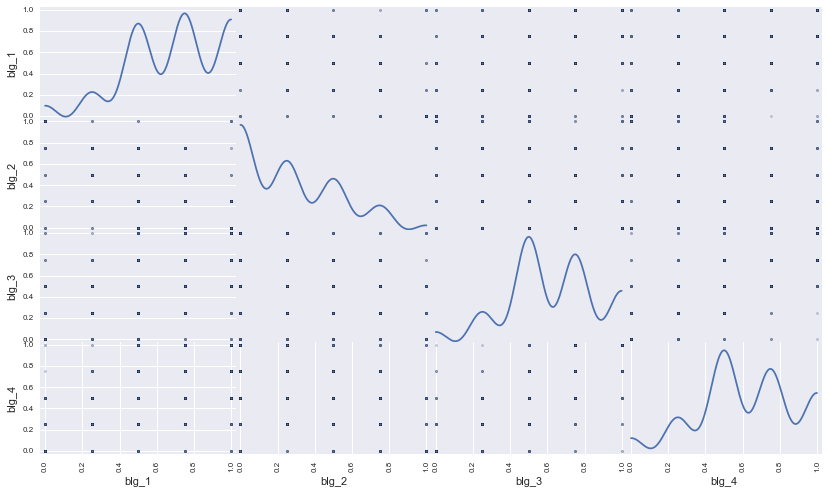

In [14]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data[itemDimensions['blg']], alpha = 0.3, figsize = (14,8), diagonal = 'kde');


From the scatterplot, it is obvious we can't make an claims about the distribution of the data. 

## Feature Transformation
We will use principal component analysis (PCA) to draw conclusions about the underlying structure of the data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe students.

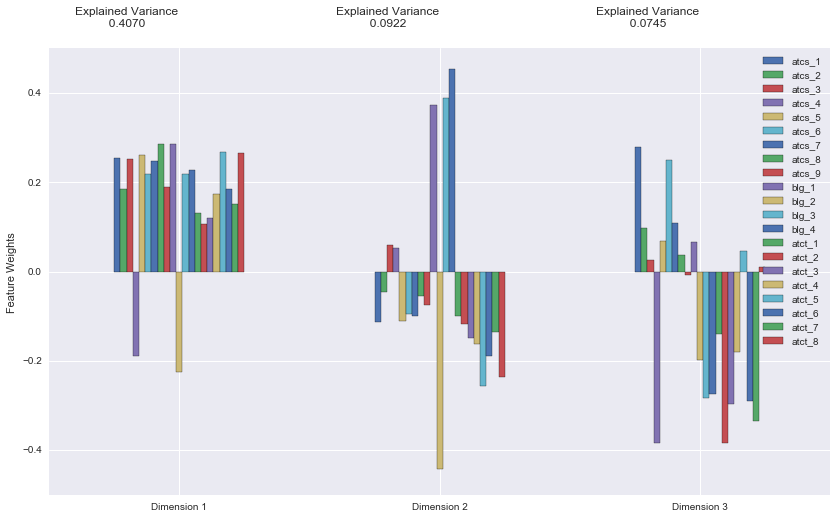

In [15]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA

pca_data = data.drop(['gender_Female', 'gender_Male'], axis=1, inplace=False)

pca = PCA(n_components=3)
pca.fit(pca_data)

# Generate PCA results plot
pca_results = tools.pca_results(pca_data, pca)

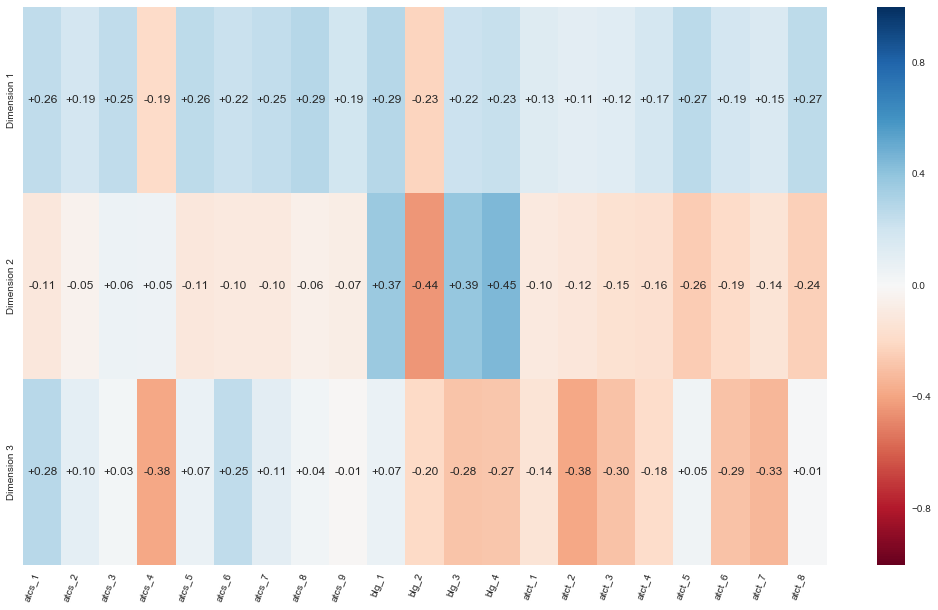

In [16]:
cols = [col for col in pca_results.columns if col not in ['Explained Variance']]
df2 = pca_results[cols]

myFileName='report/figures' + '/' + 'pcaStudentData' +'.png'
rcParams['figure.figsize'] = 18, 10
fig = figure(dpi=80) # no frame

with sns.axes_style("white"):
    ax = sns.heatmap(df2, square=False, annot=True, vmin=-1, vmax=1, cmap='RdBu', fmt='+.2f')
    plt.xticks(rotation=70, ha='right');
    
fig.savefig(myFileName)

Unsurprisingly, dimensions 1 and 2 account for almost 50% of the variance in the data. One of the interesting aspects of PCA is that the most interesting dynamics occur only in the first *k* dimension, and then they fall off. In this case, I would say the first **2** components highlight some clear student segments.    

 

#### First Principal Component Analysis - Dimension 1
The first principal component is made up of relatively small positive weights on all features except for `atcs_4` and `blg_2`. 
- atcs_4         I do not like using computer science to solve problems.
- blg_2          In this class, I feel awkward and out of place.

This component correlates with a decrease in those two features. We can interprete this component as students who do **not** have a positive sense of belonging within intro CS. 

#### Second Principal Component Analysis - Dimension 2
The second principal component is made up of mostly small negative weights, except for the three positive belonging items.
- blg_1          In this class, I feel I belong.
- blg_3          In this class, I feel like my ideas count.
- blg_4          In this class, I feel like I matter.

This component correlates positively with these three features. We can interprete this component as students who have a clear positive sense of belonging in intro CS.


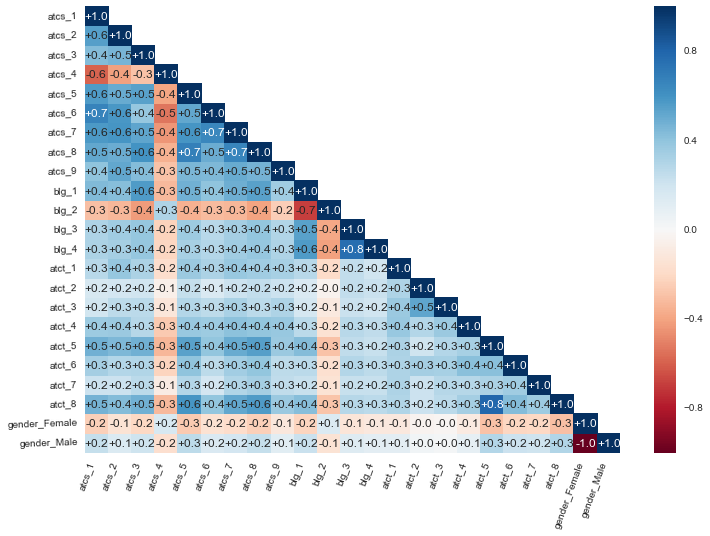

In [17]:
flattened = [val for sublist in list_of_lists for val in sublist]
df = data[flattened]
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

myFileName='report/figures' + '/' + 'corrStudentData' +'.png'
rcParams['figure.figsize'] = 12, 8
fig = figure(dpi=80) # no frame

with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=False, annot=True, vmin=-1, vmax=1,cmap='RdBu', fmt='+.1f')
    plt.xticks(rotation=70, ha='right');
    plt.yticks(rotation=2);

fig.savefig(myFileName)

We will add the first and second dimensions of the PCA as new features to our data

In [18]:
display(data.head())

,atcs_1,atcs_2,atcs_3,atcs_4,atcs_5,atcs_6,atcs_7,atcs_8,atcs_9,blg_1,...,atct_1,atct_2,atct_3,atct_4,atct_5,atct_6,atct_7,atct_8,gender_Female,gender_Male
0,0.5,0.75,1.00,0.50,0.75,0.75,0.75,0.50,0.75,0.75,...,0.75,0.75,0.75,1.0,0.50,0.75,0.75,0.25,1.0,0.0
1,0.0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.25,0.25,...,0.50,0.50,0.50,0.5,0.00,0.25,0.25,0.00,1.0,0.0
2,1.0,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,0.50,...,0.75,0.75,1.00,1.0,0.75,0.75,0.75,0.75,1.0,0.0
3,1.0,0.75,0.75,0.00,0.75,0.75,0.75,1.00,1.00,0.50,...,0.75,0.75,1.00,1.0,0.75,0.75,0.25,0.75,1.0,0.0
4,0.5,0.50,0.75,0.25,0.50,0.75,1.00,0.25,0.75,0.75,...,0.75,1.00,1.00,0.5,0.00,0.75,0.50,0.00,1.0,0.0


In [19]:
# Extract feature (X) and target (y) columns

target_col = data['gender_Male']  #  column is the target/label 

y_all = target_col  # corresponding targets/labels
X_all = data.drop(['gender_Female', 'gender_Male'], axis=1, inplace=False)

print "\nFeature values:-"
print X_all.head()  
print y_all.head()


Feature values:-
   atcs_1  atcs_2  atcs_3  atcs_4  atcs_5  atcs_6  atcs_7  atcs_8  atcs_9  \
0     0.5    0.75    1.00    0.50    0.75    0.75    0.75    0.50    0.75   
1     0.0    0.00    0.00    1.00    0.00    0.00    0.00    0.00    0.25   
2     1.0    1.00    1.00    0.00    1.00    1.00    1.00    1.00    1.00   
3     1.0    0.75    0.75    0.00    0.75    0.75    0.75    1.00    1.00   
4     0.5    0.50    0.75    0.25    0.50    0.75    1.00    0.25    0.75   

   blg_1   ...    blg_3  blg_4  atct_1  atct_2  atct_3  atct_4  atct_5  \
0   0.75   ...     0.50   0.50    0.75    0.75    0.75     1.0    0.50   
1   0.25   ...     0.00   0.00    0.50    0.50    0.50     0.5    0.00   
2   0.50   ...     0.50   0.50    0.75    0.75    1.00     1.0    0.75   
3   0.50   ...     0.50   0.75    0.75    0.75    1.00     1.0    0.75   
4   0.75   ...     0.25   0.50    0.75    1.00    1.00     0.5    0.00   

   atct_6  atct_7  atct_8  
0    0.75    0.75    0.25  
1    0.25    0.25 

### Exploratory Visualization
- As we can see the dataset is unbalanced, we have more males than females.




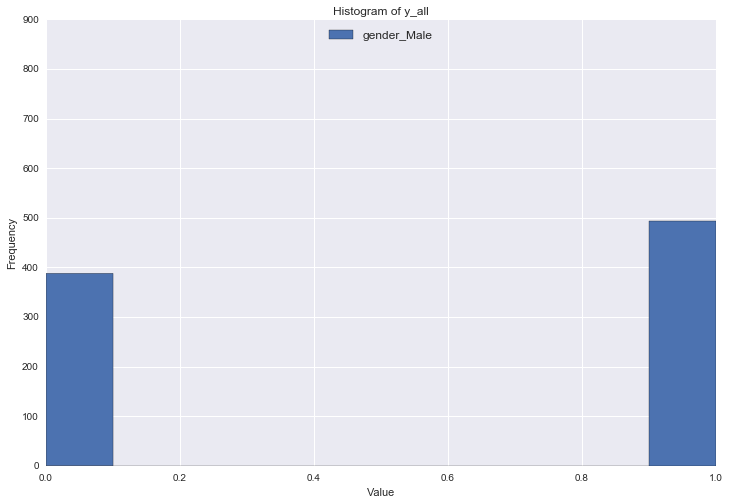

In [20]:
y_all.plot.hist()

_= pyplt.xlabel('Value')
_= pyplt.title('Histogram of y_all')
_= pyplt.legend(loc='upper center', shadow=True, fontsize='medium')
_= pyplt.yticks(np.arange(0, 1000, 100))


In [21]:
## Make sure we drop the target from the table, otherwise we will be including the labeled data

print "Feature column(s):-", list(X_all)

Feature column(s):- ['atcs_1', 'atcs_2', 'atcs_3', 'atcs_4', 'atcs_5', 'atcs_6', 'atcs_7', 'atcs_8', 'atcs_9', 'blg_1', 'blg_2', 'blg_3', 'blg_4', 'atct_1', 'atct_2', 'atct_3', 'atct_4', 'atct_5', 'atct_6', 'atct_7', 'atct_8']



### Split Data into training and testing set

#### Pro Tip:
When dealing with the new data set it is good practice to assess its specific characteristics and implement the cross validation technique tailored on those very characteristics, in our case there are two main elements:

- Our dataset is slightly unbalanced. (There are more passing students than on passing students)

We could take advantage of K-fold cross validation to exploit small data sets. Even though in this case it might not be necessary, should we have to deal with heavily unbalance datasets, we could address the unbalanced nature of our data set using Stratified K-Fold and Stratified Shuffle Split Cross validation, as stratification is preserving the preserving the percentage of samples for each class.

- http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
- http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedKFold.html

In [22]:
# First, decide how many training vs test samples you want
num_all = new_data.shape[0] 
num_train = int(num_all * 0.75)  # about 75% of the data
num_test = num_all - num_train


In [23]:
num_all

882

In [24]:
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset

# Test shuffle_split_data
try:
    X_train, y_train, X_test, y_test = tools.shuffle_split_data(X_all, y_all, num_train)
    print "Successfully shuffled and split the data!"
except:
    print "Something went wrong with shuffling and splitting the data."


print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Successfully shuffled and split the data!
Training set: 661 samples
Test set: 221 samples


## Modeling and Validating

#### Dictionary of models to run



In [25]:
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score


models = {'DecisionTree': tree.DecisionTreeClassifier(),
          'SVC': svm.SVC(),
          'RandomForest': RandomForestClassifier()
         }



In [26]:
from sklearn.metrics import f1_score

scores = [accuracy_score, precision_score, recall_score, f1_score]
score_list = []
model_score_list = []
model_name_list = []
prntLatex = 0 # key to print table optimized for insertion in Latex document.
    
for model_name, clf in models.iteritems():
# Fit model to the training data, and predict labels (for both training and test sets), and measure the F1 score. 
    tools.train_classifier(clf, X_train, y_train)
    train_time, F1_score_train, F1_score_test, prediction_time_test = tools.train_predict(clf, 
                                                                        X_train, y_train, X_test, y_test)
    tools.makeTable(clf, X_train, y_train, X_test, y_test, prntLatex)

    print "\n"

                               RandomForestClassifier
                                    Training set size
                              200	400	600
-------------------------------------------------------
Training time (secs)          0.028	0.029	0.025
Prediction time (secs)        0.001	0.001	0.001
F1 score for training set     0.985	0.988	0.981
F1 score for test set         0.601	0.632	0.582


                               DecisionTreeClassifier
                                    Training set size
                              200	400	600
-------------------------------------------------------
Training time (secs)          0.001	0.002	0.001
Prediction time (secs)        0.000	0.000	0.000
F1 score for training set     1.000	0.998	1.000
F1 score for test set         0.611	0.633	0.562


                                                  SVC
                                    Training set size
                              200	400	600
--------------------------------------------------

In [27]:
for model_name, clf in models.iteritems():
    # Create confusion matrix
    tools.makeConfusionMatrix(clf, X_test, y_test)
    print '\n\n'

         RandomForestClassifier         
                           Actual Gender
Predicted                Female    Male      
               Female    63.000    47.000    
               Male      38.000    73.000    



         DecisionTreeClassifier         
                           Actual Gender
Predicted                Female    Male      
               Female    59.000    51.000    
               Male      36.000    75.000    



                  SVC                   
                           Actual Gender
Predicted                Female    Male      
               Female    26.000    84.000    
               Male      15.000    96.000    





# Tune Model
## Proposed Procedure

1. Transform data to the format of an SVM package
2. Conduct simple scaling on the data
- Consider the RBF kernel K(x, y)
- Use cross-validation to find the best parameter C and γ
- Use the best parameter C and γ to train the whole training set
- Test

In [28]:
# TODO: Fine-tune your model and report the best F1 score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit

# Build a stratified shuffle object because of unbalanced data
ssscv = StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.3)

# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = 10. ** np.arange(-3, 5)
gamma_range = 2. ** np.arange(-5, 1)
kernel_list = ['rbf']

param_grid = dict(kernel=kernel_list, gamma=gamma_range, C=C_range)

f1_scorer = make_scorer(f1_score)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=ssscv, scoring=f1_scorer)

grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)

('The best classifier is: ', SVC(C=0.10000000000000001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.125, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))


## Validating the Model

In [29]:
print "{:>33}".format(grid.__class__.__name__)
print "-"*35

print "{:30}{:.3f}".format('F1 score for training set' ,grid.score(X_train, y_train))
print "{:30}{:.3f}".format('F1 score for test set' ,grid.score(X_test, y_test))
print "\nBest params: {}".format( grid.best_params_ )

                     GridSearchCV
-----------------------------------
F1 score for training set     0.751
F1 score for test set         0.667

Best params: {'kernel': 'rbf', 'C': 0.10000000000000001, 'gamma': 0.125}


/Users/omojumiller/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


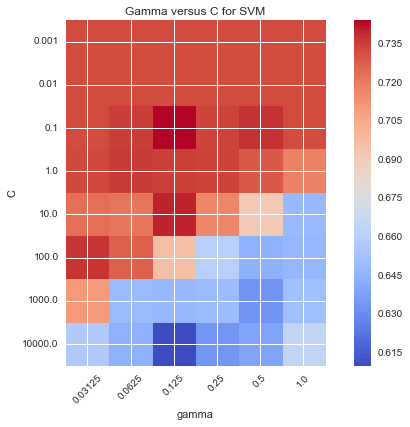

In [30]:
# grid_scores_ contains parameter settings and scores
score_dict = grid.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Make a nice figure
pyplt.figure(figsize=(10, 6))
pyplt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pyplt.imshow(scores, interpolation='nearest', cmap=pyplt.cm.coolwarm)
pyplt.title('Gamma versus C for SVM')
pyplt.xlabel('gamma')
pyplt.ylabel('C')
pyplt.colorbar()
pyplt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
pyplt.yticks(np.arange(len(C_range)), C_range)
pyplt.show()


## Bias $C$ to correct for class imbalance

As previously stated, there are more examples of student success than failure. As such, the optimal learner for this problem is one that can still generate reasonable classification given the unbalanced dataset. SVMs have a method of *biasing* the soft-margin constant, $C$, to correct for class imbalances. 
- The solution is to assign a different soft-margin constant to each class.

## Pipelining
You could actually go well beyond grid search and implement ‘pipelines’ where the whole machine learning process becomes 'grid-searchable' and you can parameterize and search the whole process though cross validation.
http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

And yes you can try out several algorithms automatically as well too! Watch out though this is pretty advanced stuff, here is a great, informative, top notch tutorial from Zac Sewart!
http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html